# **Red Wine Quality Prediction** 

## Import Libraries

In [ ]:
# ============== Import Libraries ==============

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Mengatur tampilan visualisasi
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## Data Understanding

### Load Data

In [ ]:
# ============== Data Understanding - Load Data ==============

file_path = './datasets/winequality-red.csv'
try:
    df = pd.read_csv(file_path, sep=';')
    print("Dataset loaded successfully!")
    print("Shape of dataset:", df.shape)
except FileNotFoundError:
    print(f"Error: File '{file_path}' not found. Please check the file path.")

if 'df' in locals():
    print("\nFirst 5 rows of the dataset:")
    print(df.head())

    print("\nDataset Info:")
    df.info()

    print("\nDescriptive Statistics:")
    print(df.describe())

    print("\nChecking for missing values:")
    print(df.isnull().sum())
    
    print("\nChecking for duplicate rows:")
    print(df.duplicated().sum())
    
    print("\nUnique values in each column:")
    for column in df.columns:
        print(f"{column}: {df[column].nunique()} unique values")
    print("\nData types of each column:")
    print(df.dtypes)
else:
    print("Dataset could not be loaded. Please check the file path and try again.")

Dataset loaded successfully!
Shape of dataset: (1599, 12)

First 5 rows of the dataset:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

### EDA (Exploratory Data Analysis)

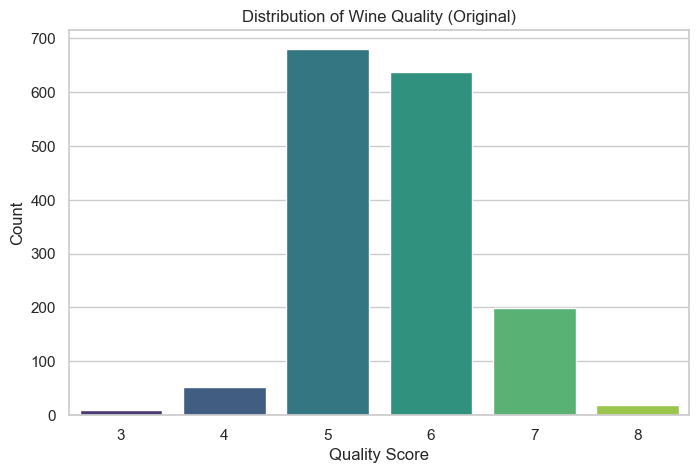

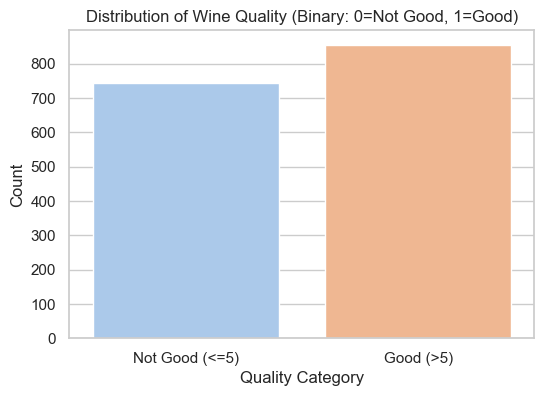


Checking for missing values after transformation:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality_category        0
dtype: int64

Checking for duplicate rows after transformation:
240

Value counts for 'quality_category':
quality_category
1    855
0    744
Name: count, dtype: int64
Class imbalance ratio (Not Good : Good): 0.8701754385964913


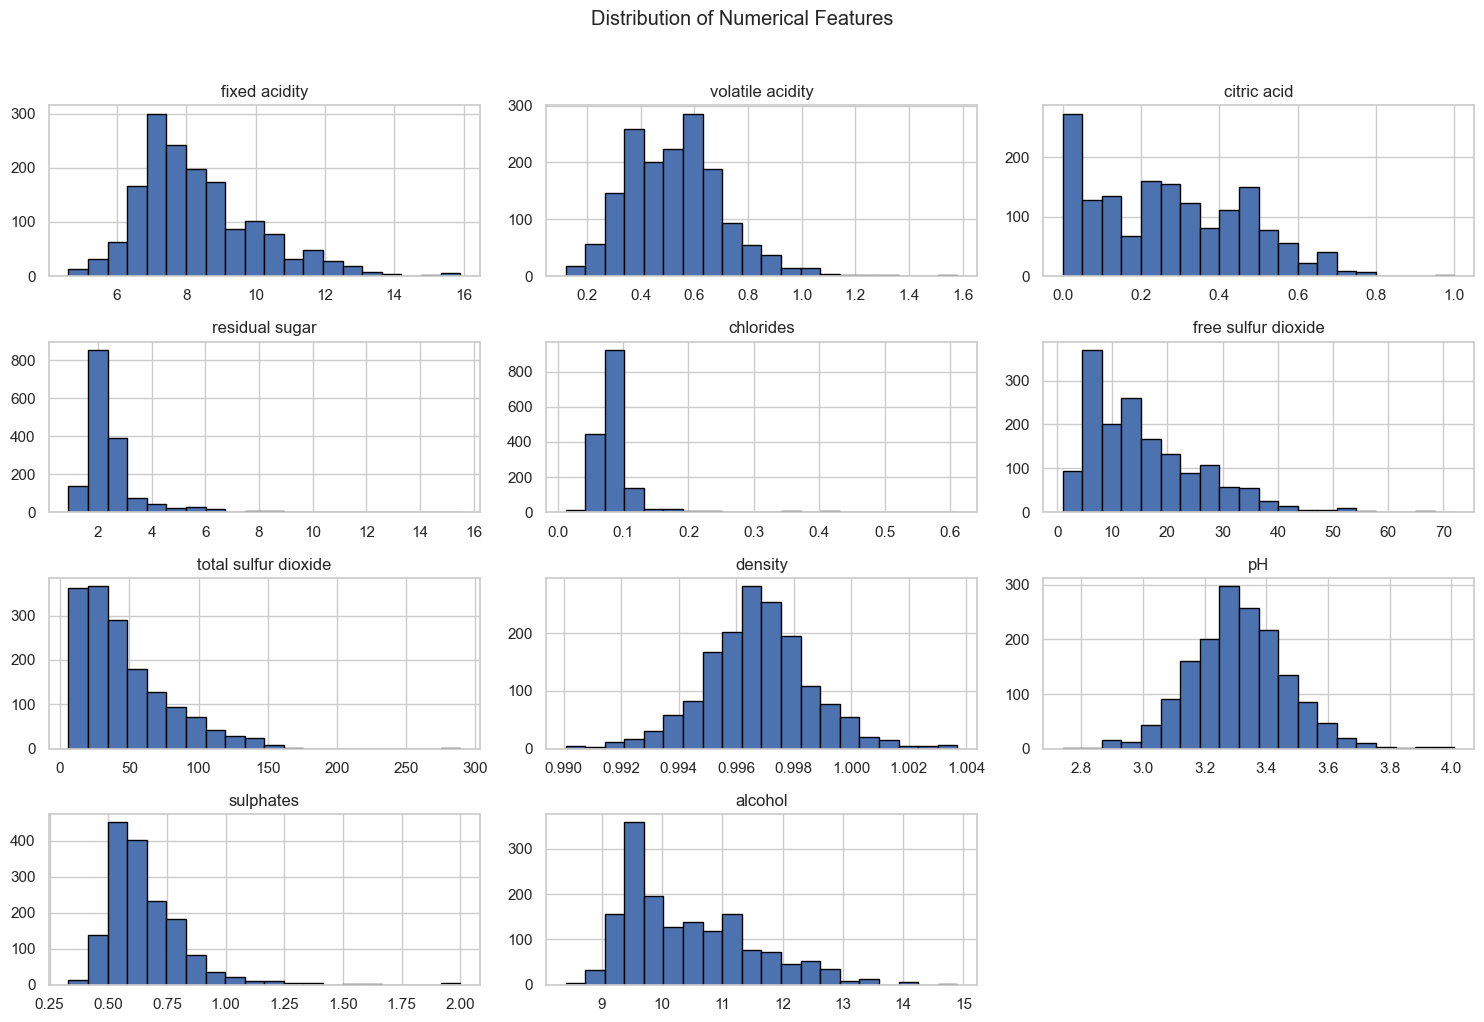

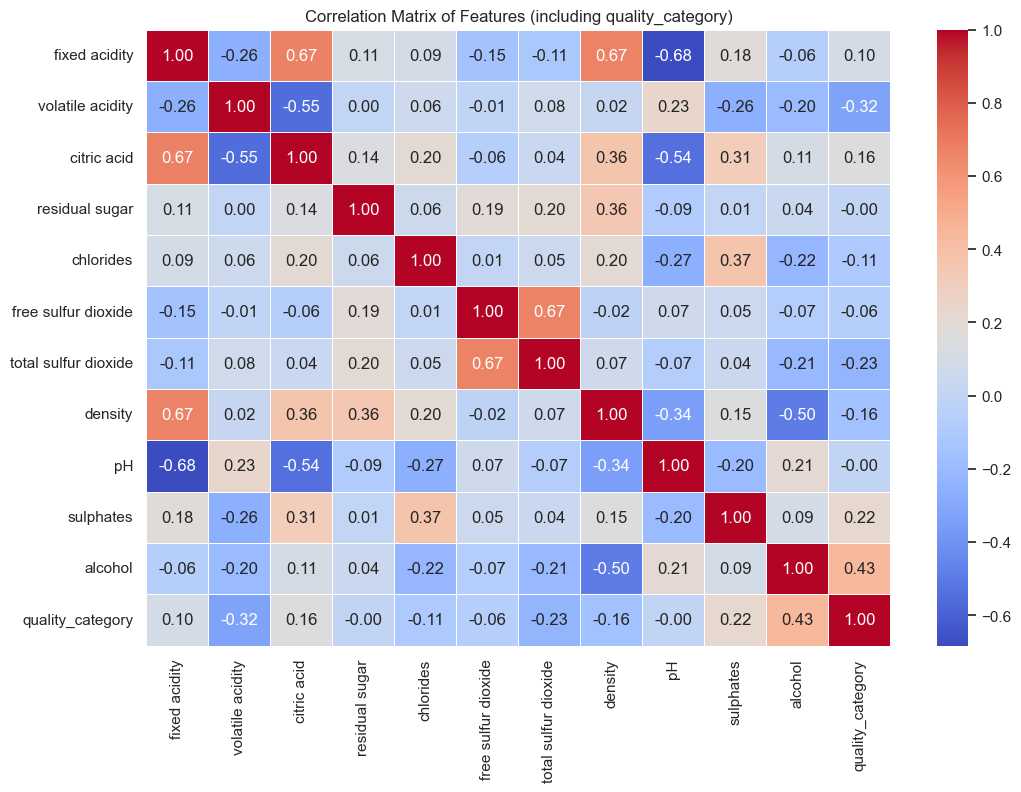


Original 'quality' column was already dropped or not present.


In [ ]:
# ============== Data Understanding - EDA (Exploratory Data Analysis) ==============

if 'df' in locals():
    # Distribusi variabel target 'quality' sebelum transformasi
    plt.figure(figsize=(8, 5))
    sns.countplot(x='quality', data=df, palette='viridis')
    plt.title('Distribution of Wine Quality (Original)')
    plt.xlabel('Quality Score')
    plt.ylabel('Count')
    plt.show()

    # Membuat kategori biner untuk 'quality'
    # 'good' (1) if quality > 5, else 'bad' (0)
    # Alternatif threshold umum: quality > 6 (good) vs <=6 (bad) atau quality >=7 (good) vs <7 (bad)
    # Menggunakan threshold > 5 untuk "good" untuk mencoba mendapatkan lebih banyak sampel di kelas "good"
    df['quality_category'] = df['quality'].apply(lambda x: 1 if x > 5 else 0)
    df.drop('quality', axis=1, inplace=True) # Hapus kolom quality asli setelah transformasi

    # Distribusi variabel target 'quality_category' setelah transformasi
    plt.figure(figsize=(6, 4))
    sns.countplot(x='quality_category', data=df, palette='pastel')
    plt.title('Distribution of Wine Quality (Binary: 0=Not Good, 1=Good)')
    plt.xlabel('Quality Category')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['Not Good (<=5)', 'Good (>5)'])
    plt.show()
    
    # Cek apakah ada nilai yang hilang setelah transformasi
    print("\nChecking for missing values after transformation:")
    print(df.isnull().sum())
    
    # Cek apakah ada duplikat setelah transformasi
    print("\nChecking for duplicate rows after transformation:")
    print(df.duplicated().sum())
    
    # Cek distribusi nilai 'quality_category'
    print("\nValue counts for 'quality_category':")
    class_counts = df['quality_category'].value_counts()
    print(class_counts)
    print("Class imbalance ratio (Not Good : Good):", class_counts[0] / class_counts[1])
    
    # Visualisasi distribusi fitur kategorikal
    categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
    for col in categorical_features:
        plt.figure(figsize=(8, 4))
        sns.countplot(x=col, hue='quality_category', data=df, palette='pastel')
        plt.title(f'Distribution of {col} by Quality Category')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.legend(title='Quality Category', loc='upper right', labels=['Not Good (<=5)', 'Good (>5)'])
        plt.show()

    # Visualisasi distribusi fitur numerik
    numerical_features = df.select_dtypes(include=np.number).columns.tolist()
    # Hapus 'quality' asli dan 'quality_category' dari daftar fitur untuk histogram
    features_for_hist = [col for col in numerical_features if col not in ['quality', 'quality_category']]

    if len(features_for_hist) == 0:
        print("No numerical features available for histogram plotting.")
    else:
        df[features_for_hist].hist(bins=20, figsize=(15, 10), layout=(-1, 3), edgecolor='black')
        plt.suptitle('Distribution of Numerical Features', y=1.02)
        plt.tight_layout()
        plt.show()

    # Korelasi antar fitur
    plt.figure(figsize=(12, 8))
    temp_df_for_corr = df.copy()
    if 'quality' in temp_df_for_corr.columns: # Pastikan 'quality' asli masih ada untuk korelasi ini, atau gunakan quality_category
         correlation_matrix = temp_df_for_corr.corr()
         sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
         plt.title('Correlation Matrix of Features (including original quality)')
         plt.show()
    else: # Jika 'quality' sudah di-drop dan 'quality_category' ada
         correlation_matrix = df.corr() # Ini akan menyertakan quality_category
         sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
         plt.title('Correlation Matrix of Features (including quality_category)')
         plt.show()

    # Hapus kolom 'quality' asli karena kita sudah punya 'quality_category'
    if 'quality' in df.columns:
        df_prepared = df.drop('quality', axis=1)
        print("\nOriginal 'quality' column dropped, 'quality_category' will be used as target.")
    else:
        df_prepared = df.copy()
        print("\nOriginal 'quality' column was already dropped or not present.")

else:
    print("Dataset 'df' not loaded. Run previous cells.")

## Data Preparation

In [9]:
# ============== Data Preparation ==============
if 'df_prepared' in locals():
    print("Data preparation started.")
    print(f"Number of rows before removing duplicates: {len(df_prepared)}")
    df_prepared.drop_duplicates(inplace=True)
    print(f"Number of rows after removing duplicates: {len(df_prepared)}")

    X = df_prepared.drop('quality_category', axis=1)
    y = df_prepared['quality_category']
    print("\nFeatures (X) and target (y) separated.")
    print("Shape of X:", X.shape)
    print("Shape of y:", y.shape)

    # Pemisahan data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print("Data split into training and testing sets.")
    print("Shape of X_train:", X_train.shape)
    print("Shape of X_test:", X_test.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of y_test:", y_test.shape)
    print("\nProportion of classes in y_train:")
    print(y_train.value_counts(normalize=True))
    print("\nProportion of classes in y_test:")
    print(y_test.value_counts(normalize=True))


    # Feature Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test) # Hanya transform pada data test, tidak fit ulang

    # Mengubah kembali ke DataFrame untuk kemudahan inspeks
    X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    print("\nFirst 5 rows of scaled training data:")
    print(X_train_scaled_df.head())
    print("\nData preparation complete.")
else:
    print("Variable 'df_prepared' not found. Run previous cells.")

Data preparation started.
Number of rows before removing duplicates: 1599
Number of rows after removing duplicates: 1359

Features (X) and target (y) separated.
Shape of X: (1359, 11)
Shape of y: (1359,)
Data split into training and testing sets.
Shape of X_train: (1087, 11)
Shape of X_test: (272, 11)
Shape of y_train: (1087,)
Shape of y_test: (272,)

Proportion of classes in y_train:
quality_category
1    0.528979
0    0.471021
Name: proportion, dtype: float64

Proportion of classes in y_test:
quality_category
1    0.529412
0    0.470588
Name: proportion, dtype: float64

First 5 rows of scaled training data:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.805013         -0.440050    -0.827412       -0.104942  -0.891400   
1      -0.805013         -0.494360    -1.385634       -0.823728  -0.360597   
2      -0.060680         -0.548670     0.086042       -0.679971  -0.144344   
3      -1.148551          0.103049    -0.624422       -0.536214  -0.222

## Modeling

### Logistic Regression (Baseline)

In [ ]:
# ============== Modeling - Logistic Regression (Baseline) ==============

if 'X_train_scaled' in locals():
    log_reg = LogisticRegression(random_state=42, solver='liblinear') # liblinear baik untuk dataset kecil
    log_reg.fit(X_train_scaled, y_train)

    y_pred_log_reg_train = log_reg.predict(X_train_scaled)
    y_pred_log_reg_test = log_reg.predict(X_test_scaled)

    print("Logistic Regression Model Trained.")
    print("--- Evaluation on Training Data (Logistic Regression) ---")
    print(f"Accuracy: {accuracy_score(y_train, y_pred_log_reg_train):.4f}")
    print(classification_report(y_train, y_pred_log_reg_train))


    print("\n--- Evaluation on Test Data (Logistic Regression) ---")
    log_reg_accuracy = accuracy_score(y_test, y_pred_log_reg_test)
    log_reg_precision = precision_score(y_test, y_pred_log_reg_test, average='weighted') # or 'binary' if positive_label is 1
    log_reg_recall = recall_score(y_test, y_pred_log_reg_test, average='weighted')
    log_reg_f1 = f1_score(y_test, y_pred_log_reg_test, average='weighted')

    print(f"Accuracy: {log_reg_accuracy:.4f}")
    print(f"Precision (weighted): {log_reg_precision:.4f}")
    print(f"Recall (weighted): {log_reg_recall:.4f}")
    print(f"F1-score (weighted): {log_reg_f1:.4f}")
    print("\nClassification Report (Test Data):\n", classification_report(y_test, y_pred_log_reg_test))
    print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, y_pred_log_reg_test))

else:
    print("Scaled training data not found. Run previous cells.")

### Random Forest Classifier (Default Parameters)

In [ ]:
# ============== Modeling - Random Forest Classifier (Default Parameters) ==============

if 'X_train_scaled' in locals():
    rf_clf_default = RandomForestClassifier(random_state=42)
    rf_clf_default.fit(X_train_scaled, y_train)

    y_pred_rf_default_train = rf_clf_default.predict(X_train_scaled)
    y_pred_rf_default_test = rf_clf_default.predict(X_test_scaled)

    print("Random Forest (Default) Model Trained.")
    print("--- Evaluation on Training Data (Random Forest Default) ---")
    print(f"Accuracy: {accuracy_score(y_train, y_pred_rf_default_train):.4f}")
    print(classification_report(y_train, y_pred_rf_default_train))


    print("\n--- Evaluation on Test Data (Random Forest Default) ---")
    rf_default_accuracy = accuracy_score(y_test, y_pred_rf_default_test)
    rf_default_precision = precision_score(y_test, y_pred_rf_default_test, average='weighted')
    rf_default_recall = recall_score(y_test, y_pred_rf_default_test, average='weighted')
    rf_default_f1 = f1_score(y_test, y_pred_rf_default_test, average='weighted')

    print(f"Accuracy: {rf_default_accuracy:.4f}")
    print(f"Precision (weighted): {rf_default_precision:.4f}")
    print(f"Recall (weighted): {rf_default_recall:.4f}")
    print(f"F1-score (weighted): {rf_default_f1:.4f}")
    print("\nClassification Report (Test Data):\n", classification_report(y_test, y_pred_rf_default_test))
    print("\nConfusion Matrix (Test Data):\n", confusion_matrix(y_test, y_pred_rf_default_test))

    # Feature Importances
    importances = rf_clf_default.feature_importances_
    feature_names = X.columns
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='mako')
    plt.title('Feature Importances from Random Forest (Default)')
    plt.show()
    print("\nTop 5 Feature Importances:")
    print(feature_importance_df.head())
else:
    print("Scaled training data not found. Run previous cells.")

### Hyperparameter Tuning for Random Forest 

In [ ]:
# ============== Modeling - Hyperparameter Tuning for Random Forest ==============

# (Kriteria Tambahan)
# Pilih model terbaik untuk dituning. Misal Random Forest lebih baik dari Logistic Regression.
if 'X_train_scaled' in locals():
    print("\nStarting Hyperparameter Tuning for Random Forest...")
    param_grid_rf = {
        'n_estimators': [100, 200, 300],        # Jumlah pohon dalam forest
        'max_depth': [None, 10, 20, 30],        # Kedalaman maksimum pohon
        'min_samples_split': [2, 5, 10],        # Jumlah sampel minimum untuk membagi node internal
        'min_samples_leaf': [1, 2, 4],          # Jumlah sampel minimum pada leaf node
        'max_features': ['sqrt', 'log2', None]  # Jumlah fitur untuk dipertimbangkan saat mencari split terbaik
    }

    rf_grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                                  param_grid=param_grid_rf,
                                  cv=3, # Menggunakan 3-fold CV untuk kecepatan
                                  scoring=['accuracy', 'f1_weighted'],
                                  n_jobs=-1, # Menggunakan semua prosesor yang tersedia
                                  verbose=1) # Untuk melihat progress

    rf_grid_search.fit(X_train_scaled, y_train)

    print("\nHyperparameter Tuning Complete.")
    print("Best Parameters found for Random Forest:", rf_grid_search.best_params_)

    # Model terbaik dari GridSearchCV
    best_rf_clf = rf_grid_search.best_estimator_

    y_pred_rf_tuned_train = best_rf_clf.predict(X_train_scaled)
    y_pred_rf_tuned_test = best_rf_clf.predict(X_test_scaled)


    print("\n--- Evaluation on Training Data (Random Forest Tuned) ---")
    print(f"Accuracy: {accuracy_score(y_train, y_pred_rf_tuned_train):.4f}")
    print(classification_report(y_train, y_pred_rf_tuned_train))

    print("\n--- Evaluation on Test Data (Random Forest Tuned) ---")
    rf_tuned_accuracy = accuracy_score(y_test, y_pred_rf_tuned_test)
    rf_tuned_precision = precision_score(y_test, y_pred_rf_tuned_test, average='weighted')
    rf_tuned_recall = recall_score(y_test, y_pred_rf_tuned_test, average='weighted')
    rf_tuned_f1 = f1_score(y_test, y_pred_rf_tuned_test, average='weighted')

    print(f"Accuracy: {rf_tuned_accuracy:.4f}")
    print(f"Precision (weighted): {rf_tuned_precision:.4f}")
    print(f"Recall (weighted): {rf_tuned_recall:.4f}")
    print(f"F1-score (weighted): {rf_tuned_f1:.4f}")
    print("\nClassification Report (Test Data - Tuned):\n", classification_report(y_test, y_pred_rf_tuned_test))
    print("\nConfusion Matrix (Test Data - Tuned):\n", confusion_matrix(y_test, y_pred_rf_tuned_test))

else:
    print("Scaled training data not found. Run previous cells.")

##  Evaluation - Summary of Results 

In [ ]:
# ============== Evaluation - Summary of Results ==============

if 'log_reg_accuracy' in locals() and 'rf_default_accuracy' in locals() and 'rf_tuned_accuracy' in locals():
    results_summary = pd.DataFrame({
        'Model': ['Logistic Regression', 'Random Forest (Default)', 'Random Forest (Tuned)'],
        'Accuracy': [log_reg_accuracy, rf_default_accuracy, rf_tuned_accuracy],
        'Precision (Weighted)': [log_reg_precision, rf_default_precision, rf_tuned_precision],
        'Recall (Weighted)': [log_reg_recall, rf_default_recall, rf_tuned_recall],
        'F1-score (Weighted)': [log_reg_f1, rf_default_f1, rf_tuned_f1]
    })

    results_summary = results_summary.set_index('Model')
    print("\n--- Summary of Model Performance on Test Data ---")
    print(results_summary)

    # Plotting F1-scores for comparison
    plt.figure(figsize=(10, 6))
    sns.barplot(x=results_summary.index, y='F1-score (Weighted)', data=results_summary.reset_index(), palette='magma')
    plt.title('Comparison of Model F1-scores (Weighted) on Test Data')
    plt.ylabel('F1-score (Weighted)')
    plt.xticks(rotation=15)
    for index, row in results_summary.reset_index().iterrows():
        plt.text(row.name, row['F1-score (Weighted)'] + 0.01, f"{row['F1-score (Weighted)']:.3f}", color='black', ha="center")
    plt.show()

    print("\nDetailed Explanation of Metrics (Kriteria Tambahan for Evaluation):")
    print("""
    - Akurasi: Proporsi prediksi yang benar secara keseluruhan. (TP+TN)/(TP+TN+FP+FN).
      Cara kerja: Memberikan gambaran umum seberapa sering model benar.
    - Presisi (Weighted): Rata-rata presisi per kelas, dibobot berdasarkan jumlah sampel sebenarnya per kelas.
      Untuk kelas positif (misal 'Good Wine'): TP / (TP+FP).
      Cara kerja: Dari semua yang diprediksi sebagai 'Good Wine', berapa persen yang benar-benar 'Good Wine'. Penting untuk menghindari false alarm.
    - Recall (Weighted): Rata-rata recall per kelas, dibobot berdasarkan jumlah sampel sebenarnya per kelas.
      Untuk kelas positif: TP / (TP+FN).
      Cara kerja: Dari semua yang sebenarnya 'Good Wine', berapa persen yang berhasil diidentifikasi oleh model. Penting untuk tidak melewatkan kasus positif.
    - F1-score (Weighted): Rata-rata F1-score per kelas, dibobot. F1-score per kelas adalah rata-rata harmonik dari presisi dan recall (2*(Presisi*Recall)/(Presisi+Recall)).
      Cara kerja: Memberikan keseimbangan antara presisi dan recall, berguna terutama jika ada ketidakseimbangan kelas atau jika kedua metrik (presisi dan recall) sama pentingnya.
    """)
else:
    print("Model evaluation results not found. Run previous cells.")

print("\n--- End of Project ---")